In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv("all_sales_boston_with_macro_filtered.csv")

In [4]:
data["sale_price_real_2023"].describe()

count    2.931600e+04
mean     9.736868e+05
std      9.870291e+05
min      1.020000e+00
25%      5.662375e+05
50%      7.649318e+05
75%      1.072508e+06
max      4.018708e+07
Name: sale_price_real_2023, dtype: float64

In [5]:
print(data["sale_price_real_2023"].isna().sum()) 

0


In [6]:
print(data["living_area"].isna().sum())  

0


In [7]:
# data_21.columns

for col in data.columns:
    print(col)

unit
street_name
sale_date
parcel
category
sale_price
street_no
price_per_sf
living_area
total_room_num
bedrooms
bathrooms
half_bathrooms
kitchens
fireplaces
ac_type
heat_type
interior_condition
parking_spots
year_built
exterior_condition
foundation
full_address
owner_name
owner_property_count
x
y
properties
year
modified_z
NEAR_FID
NEAR_DIST_Parks
NEAR_DIST_Health
NEAR_FC
NEAR_DIST_Safety
NEAR_DIST_University
NEAR_DIST_Security
NEAR_DIST_Subway
NEAR_DIST_Culture
NEAR_DIST_Culture_District
NEAR_COUNT_Schools
NEAR_COUNT_Bus
NEAR_COUNT_Trees
NEAR_COUNT_Restaurants
quarter
GDP
GDP_YoY
month
CPI
CPI_YoY
sale_price_real_2023
price_per_sf_real_2023


In [8]:
# check the bedroom nan portion
print(data["bedrooms"].isnull().sum() / len(data))

# drop the bedroom nan
# data_21 = data_21.dropna(subset=['BED_RMS'])

# check the bedroom nan portion
# data_21["BED_RMS"].isnull().sum() / len(data_21)



0.0


In [9]:
len(data)

29316

In [10]:
# rename column x and y to Longitude and Latitude
data = data.rename(columns={'x': 'Longitude', 'y': 'Latitude'})


In [11]:
data = pd.get_dummies(data, columns=["category"], drop_first=True)


In [12]:


# categorical columns start with "category"
categorica_columns = [col for col in data.columns if col.startswith("category")]
print(categorica_columns)

# change the categorical columns to integer
data[categorica_columns] = data[categorica_columns].astype(int)


['category_single_family', 'category_three_family', 'category_two_family']


In [13]:
# Cehck any null among x_columns
X_common = ["bedrooms",\
            "GDP_YoY",\
            "CPI_YoY",\
            "living_area",\
            "Longitude",\
            "Latitude",\
            "NEAR_DIST_Parks",\
            "NEAR_DIST_Health",\
            "NEAR_DIST_Safety",\
            "NEAR_DIST_University",\
            "NEAR_DIST_Security",\
            "NEAR_DIST_Subway",\
            "NEAR_COUNT_Schools",\
            "NEAR_COUNT_Bus",\
            "NEAR_COUNT_Trees"]
culture_column = ["NEAR_DIST_Culture"]
culture_district_column = ["NEAR_DIST_Culture_District"]

# Remove Living Area NaN values
# data = data[data["LIVING_AREA"].notna()]
X1_cols = X_common + culture_column
X2_cols = X_common + culture_district_column

X_columns_null = [col for col in X1_cols if data[col].isnull().any()]
print(X_columns_null)

# fill in the null values with 0
data[X_columns_null] = data[X_columns_null].fillna(0)


[]


In [14]:
X1_cols

['bedrooms',
 'GDP_YoY',
 'CPI_YoY',
 'living_area',
 'Longitude',
 'Latitude',
 'NEAR_DIST_Parks',
 'NEAR_DIST_Health',
 'NEAR_DIST_Safety',
 'NEAR_DIST_University',
 'NEAR_DIST_Security',
 'NEAR_DIST_Subway',
 'NEAR_COUNT_Schools',
 'NEAR_COUNT_Bus',
 'NEAR_COUNT_Trees',
 'NEAR_DIST_Culture']

In [49]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
import shap
from sklearn.utils import resample
from sklearn.metrics import r2_score
from tqdm.auto import trange   # progress bar

def bootstrap_xgb(X, y, B=300, random_state=0):
    rng = np.random.RandomState(random_state)
    n = len(y)
    r2_scores = np.empty(B)
    shap_means = np.zeros((B, X.shape[1]))  # mean |ϕ| per feature

    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )

    for b in trange(B, desc="Bootstrapping"):
        # ----- 1. sample with replacement -----
        idx_boot = rng.choice(n, size=n, replace=True)
        idx_oob  = np.setdiff1d(np.arange(n), idx_boot)
        X_boot, y_boot = X.iloc[idx_boot], y.iloc[idx_boot]
        X_oob,  y_oob  = X.iloc[idx_oob],  y.iloc[idx_oob]

        # ----- 2. fit -----
        model.fit(X_boot, y_boot)

        # ----- 3. evaluate R² on OOB -----
        y_pred = model.predict(X_oob)
        r2_scores[b] = r2_score(y_oob, y_pred)

        # ----- 4. SHAP on OOB (TreeExplainer is fast) -----
        explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
        shap_vals = explainer.shap_values(X_oob, check_additivity=False)
        shap_means[b] = np.abs(shap_vals).mean(axis=0)

    return r2_scores, shap_means, X.columns


# ---------- run for the two specs ----------
Y = data["sale_price"]

r2_a, shap_a, feat_a = bootstrap_xgb(data[X1_cols], Y, B=300, random_state=1)
r2_b, shap_b, feat_b = bootstrap_xgb(data[X2_cols], Y, B=300, random_state=1)

# delta distribution
delta_r2 = r2_b - r2_a
mean_delta = delta_r2.mean()
ci_delta   = np.percentile(delta_r2, [2.5, 97.5])
p_value    = np.mean(delta_r2 <= 0)

print(f"ΔR² mean = {mean_delta:.4f}, 95% CI [{ci_delta[0]:.4f}, {ci_delta[1]:.4f}], p = {p_value:.3f}")

Bootstrapping:   0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [99]:
print(r2_a)
print(r2_b)

[0.79123861 0.7661137  0.70279604 0.78383589 0.7325393  0.70572406
 0.68666089 0.73164243 0.71615708 0.70871389 0.76516509 0.74000359
 0.7774173  0.6869992  0.74179077 0.71921766 0.70475709 0.67893326
 0.68755138 0.72531569 0.69617116 0.76965225 0.5992825  0.73432386
 0.78261513 0.72419184 0.6885438  0.74123204 0.74459624 0.73627579
 0.77229291 0.77806187 0.7084775  0.78327978 0.7721014  0.74526644
 0.64787149 0.72015119 0.77938163 0.71695483 0.76298463 0.72770059
 0.68936682 0.75594914 0.77722859 0.72517705 0.75730431 0.76964831
 0.73640668 0.77652138 0.69379926 0.71651149 0.70803773 0.77148801
 0.71742308 0.75852418 0.69570559 0.68132722 0.6894747  0.63772029
 0.69167614 0.76301891 0.71048313 0.78445482 0.76092219 0.7711817
 0.7632944  0.7711032  0.74819362 0.698511   0.7961086  0.7396515
 0.7336514  0.72556102 0.77500272 0.68346429 0.79991388 0.77632052
 0.66826177 0.79354048 0.74630749 0.6768927  0.78196669 0.68419933
 0.69422317 0.69905084 0.77808595 0.67943919 0.7486518  0.719374

In [15]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold



# create a model to predict the real increase percent
Y = data["sale_price_real_2023"]
X1 = data[X1_cols]

# Initialize model with same parameters
model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )

# model = XGBRegressor()


# Perform 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X1, Y, cv=kf, scoring='r2')

# Print cross validation results
print("Cross Validation Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")
print(f"\nMean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Fit the model on the full dataset to get feature importances
model.fit(X1, Y)

# Print feature importances
print("\nFeature importances:")
print(model.feature_importances_)


Cross Validation Scores:
Fold 1: 0.8862
Fold 2: 0.9179
Fold 3: 0.9108
Fold 4: 0.9178
Fold 5: 0.8404

Mean CV Score: 0.8946
Standard Deviation: 0.0295

Feature importances:
[0.0500459  0.01373232 0.00929772 0.24025019 0.04080572 0.13197966
 0.04796557 0.0490445  0.01866166 0.13495052 0.05574188 0.03414012
 0.02274214 0.01817747 0.01352173 0.1189429 ]


In [16]:
# Get feature importances from XGBoost model
importances = model.feature_importances_

# Create dictionary mapping features to their importance scores
importance_dict = dict(zip(X1.columns, importances))

# Print feature importances in order
print("Feature Importances:")
for feature, importance in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")


Feature Importances:
living_area: 0.2403
NEAR_DIST_University: 0.1350
Latitude: 0.1320
NEAR_DIST_Culture: 0.1189
NEAR_DIST_Security: 0.0557
bedrooms: 0.0500
NEAR_DIST_Health: 0.0490
NEAR_DIST_Parks: 0.0480
Longitude: 0.0408
NEAR_DIST_Subway: 0.0341
NEAR_COUNT_Schools: 0.0227
NEAR_DIST_Safety: 0.0187
NEAR_COUNT_Bus: 0.0182
GDP_YoY: 0.0137
NEAR_COUNT_Trees: 0.0135
CPI_YoY: 0.0093


In [17]:
print(data[X1.columns].isnull().sum())

bedrooms                0
GDP_YoY                 0
CPI_YoY                 0
living_area             0
Longitude               0
Latitude                0
NEAR_DIST_Parks         0
NEAR_DIST_Health        0
NEAR_DIST_Safety        0
NEAR_DIST_University    0
NEAR_DIST_Security      0
NEAR_DIST_Subway        0
NEAR_COUNT_Schools      0
NEAR_COUNT_Bus          0
NEAR_COUNT_Trees        0
NEAR_DIST_Culture       0
dtype: int64


100%|===================| 29280/29316 [11:03<00:00]        

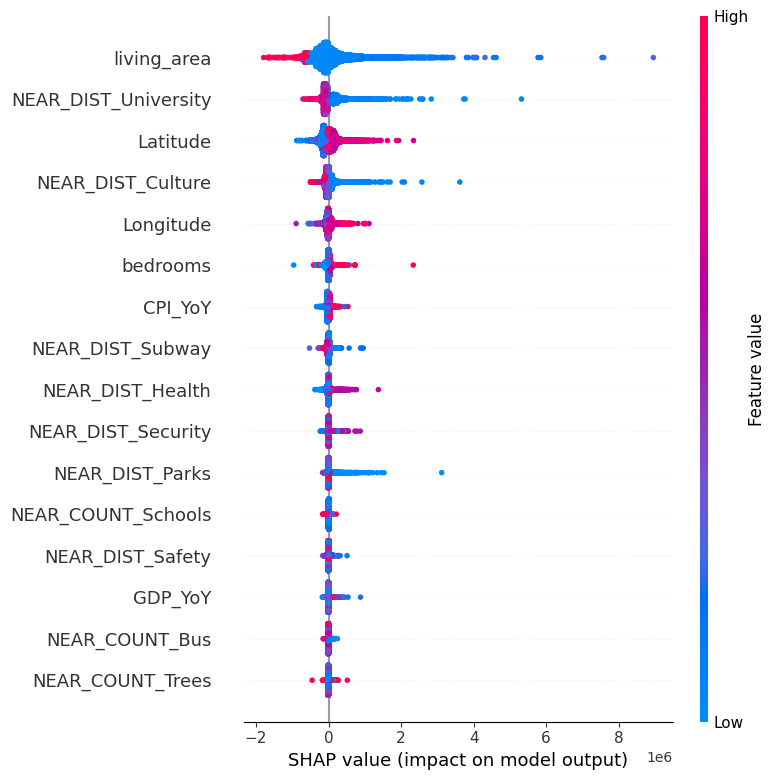

In [53]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.Explainer(model, X1)

# Calculate SHAP values
shap_values1 = explainer(X1)

# Create SHAP summary plot
shap.summary_plot(shap_values1, X1)  # You can use "bar" for bar plot


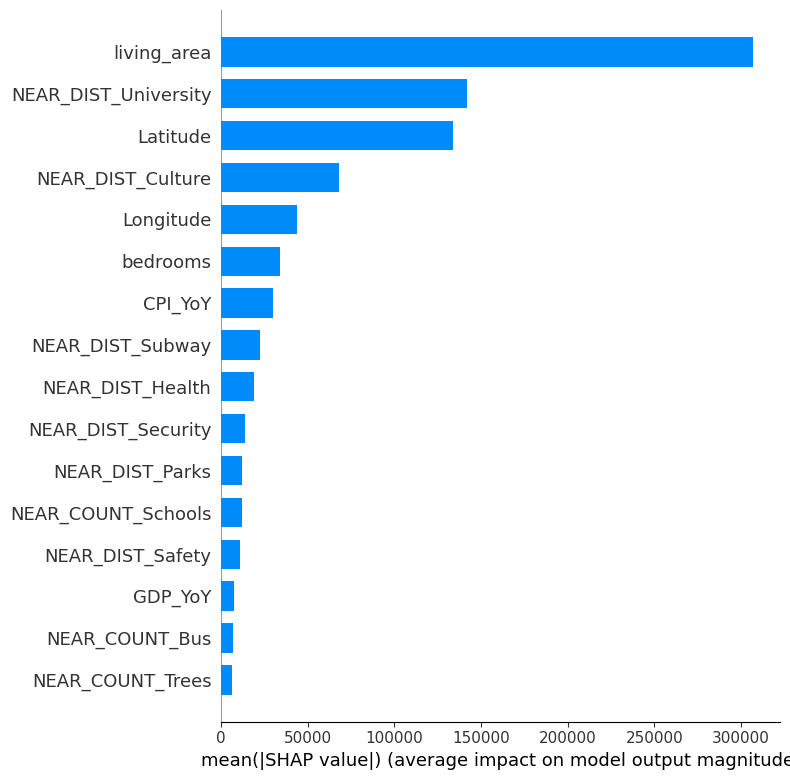

In [54]:
# plot a bar chart of the feature importances

shap.summary_plot(shap_values1, X1, plot_type="bar")

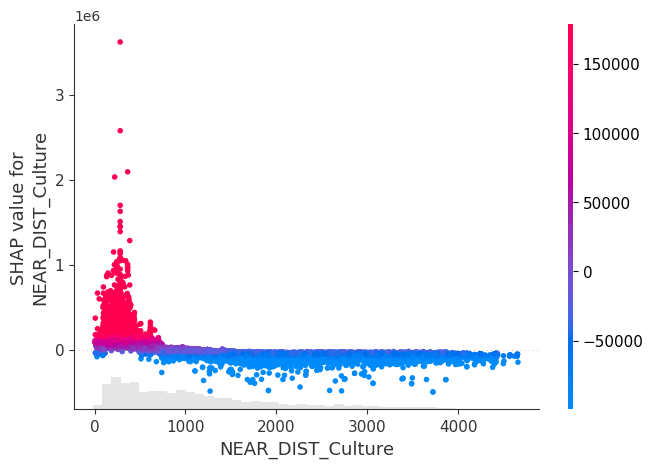

In [55]:
shap.plots.scatter(
    shap_values1[:, "NEAR_DIST_Culture"],
    color=shap_values1[:, "NEAR_DIST_Culture"].values,  # SHAP values as color
)

In [56]:
shap_df = pd.DataFrame(shap_values1.values, columns=X1.columns)
# save df
shap_df.to_csv('data/shap_values.csv', index=False)


In [57]:
len(data)

29316

In [58]:
# now we do with the mixed culture district
X2 = data[X2_cols]

# Initialize model with same parameters
# model = XGBRegressor()

model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )


# Perform 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X2, Y, cv=kf, scoring='r2')

# Print cross validation results
print("Cross Validation Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")
print(f"\nMean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Fit the model on the full dataset to get feature importances
model.fit(X2, Y)

# Print feature importances
print("\nFeature importances:")
print(model.feature_importances_)

Cross Validation Scores:
Fold 1: 0.9213
Fold 2: 0.9218
Fold 3: 0.8492
Fold 4: 0.8841
Fold 5: 0.9139

Mean CV Score: 0.8980
Standard Deviation: 0.0281

Feature importances:
[0.04455176 0.01252851 0.00971176 0.22844437 0.03703934 0.14165571
 0.03892516 0.04315365 0.01359681 0.06690881 0.05445464 0.0198497
 0.02554983 0.01053861 0.01226762 0.24082367]


In [59]:
# Get feature importances from XGBoost model
importances = model.feature_importances_

# Create dictionary mapping features to their importance scores
importance_dict = dict(zip(X2.columns, importances))

# Print feature importances in order
print("Feature Importances:")
for feature, importance in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")


Feature Importances:
NEAR_DIST_Culture_District: 0.2408
living_area: 0.2284
Latitude: 0.1417
NEAR_DIST_University: 0.0669
NEAR_DIST_Security: 0.0545
bedrooms: 0.0446
NEAR_DIST_Health: 0.0432
NEAR_DIST_Parks: 0.0389
Longitude: 0.0370
NEAR_COUNT_Schools: 0.0255
NEAR_DIST_Subway: 0.0198
NEAR_DIST_Safety: 0.0136
GDP_YoY: 0.0125
NEAR_COUNT_Trees: 0.0123
NEAR_COUNT_Bus: 0.0105
CPI_YoY: 0.0097


In [ ]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.Explainer(model, X2)

# Calculate SHAP values
shap_values2 = explainer(X2)

# Create SHAP summary plot
shap.summary_plot(shap_values2, X2)  # You can use "bar" for bar plot


  9%|==                  | 2544/29316 [01:02<10:52]       

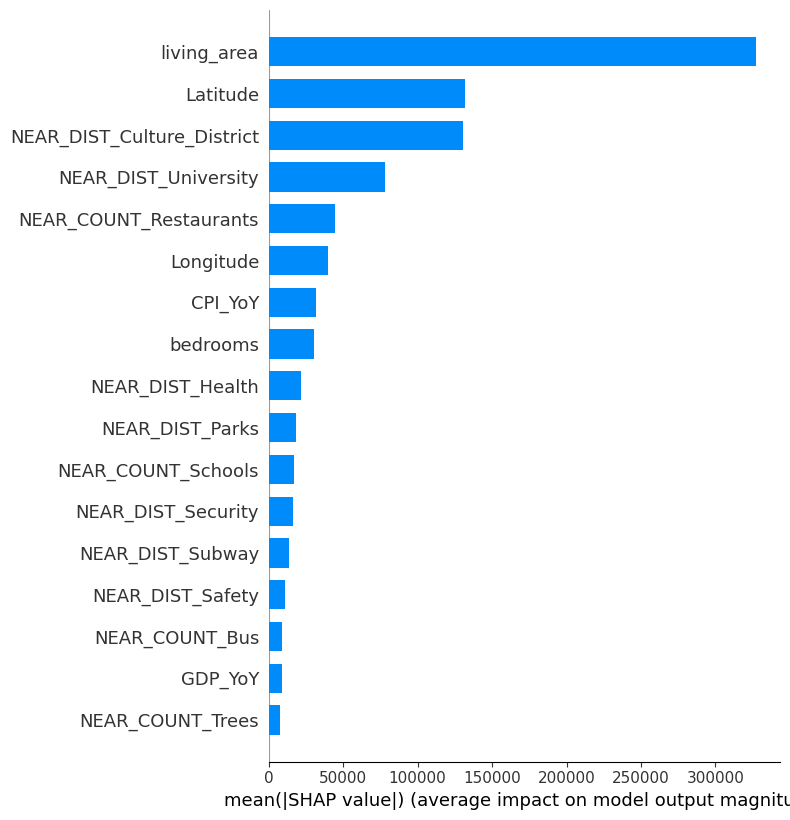

In [ ]:
# plot a bar chart of the feature importances

shap.summary_plot(shap_values2, X2, plot_type="bar")

In [ ]:
shap.plots.scatter(shap_values2[:, "NEAR_DIST_Culture_District"],
                   color=X2["NEAR_DIST_Culture_District"].values)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [126]:
X_common

['bedrooms',
 'living_area',
 'Longitude',
 'Latitude',
 'NEAR_DIST_Parks',
 'NEAR_DIST_Health',
 'NEAR_DIST_Safety',
 'NEAR_DIST_University',
 'NEAR_DIST_Security',
 'NEAR_DIST_Subway',
 'NEAR_COUNT_Schools',
 'NEAR_COUNT_Bus',
 'NEAR_COUNT_Trees']

In [45]:
all_x = X_common + ["NEAR_DIST_Culture", "NEAR_DIST_Culture_District"]

# now we do with all the data
X = data[all_x]

# Initialize model with same parameters
model = XGBRegressor()


# Perform 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, Y, cv=kf, scoring='r2')

# Print cross validation results
print("Cross Validation Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")
print(f"\nMean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Fit the model on the full dataset to get feature importances
model.fit(X, Y)

# Print feature importances
print("\nFeature importances:")
print(model.feature_importances_)

Cross Validation Scores:
Fold 1: 0.4637
Fold 2: 0.3671
Fold 3: 0.3309
Fold 4: 0.4191
Fold 5: 0.2842

Mean CV Score: 0.3730
Standard Deviation: 0.0633

Feature importances:
[0.05825448 0.05414545 0.02803902 0.04759371 0.0369596  0.02952042
 0.02624639 0.0394957  0.04015504 0.02289393 0.02368708 0.43998384
 0.05270435 0.05377636 0.04654453]


In [46]:
# Get feature importances from XGBoost model
importances = model.feature_importances_

# Create dictionary mapping features to their importance scores
importance_dict = dict(zip(X.columns, importances))

# Print feature importances in order
print("Feature Importances:")
for feature, importance in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")


Feature Importances:
Latitude: 0.4400
GROSS_AREA: 0.0583
BED_RMS: 0.0541
NEAR_DIST_Culture: 0.0538
Longitude: 0.0527
NEAR_DIST_Health: 0.0476
NEAR_DIST_Mixed_Culture_District: 0.0465
NEAR_DIST_University: 0.0402
NEAR_DIST_Subway: 0.0395
NEAR_DIST_Park: 0.0370
NEAR_DIST_Safety: 0.0295
BUS_CNT: 0.0280
NEAR_DIST_Security: 0.0262
TREE_CNT: 0.0237
SCHOOL_CNT: 0.0229


100%|===================| 119727/120158 [02:50<00:00]        

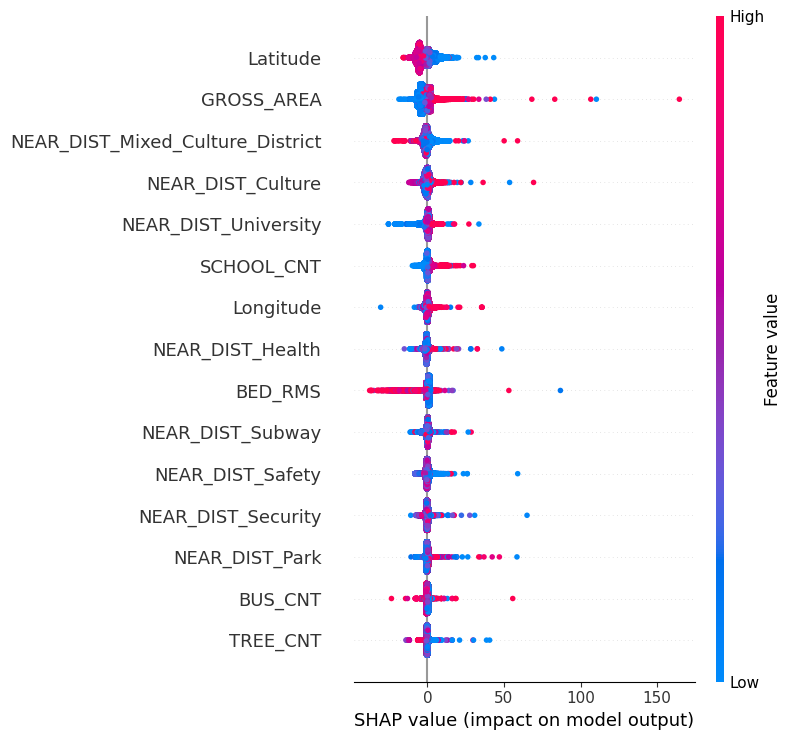

In [47]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.Explainer(model, X)

# Calculate SHAP values
shap_values = explainer(X)

# Create SHAP summary plot
shap.summary_plot(shap_values, X)  # You can use "bar" for bar plot


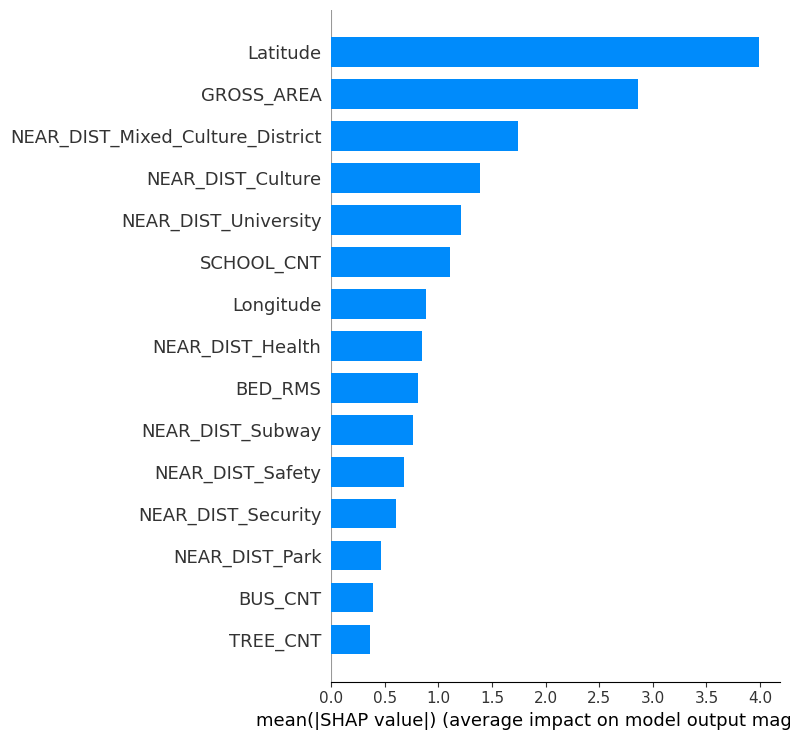

In [48]:
# plot a bar chart of the feature importances

shap.summary_plot(shap_values, X, plot_type="bar")